# Please read me first
- Make sure 'train_data.xlsx' and 'all_combos.xlsx' are in the folder 'LabMate-AI'

Welcome! Let me work out what is the best experiment for you to run...

Start: 2019/09/18  14:33:38

Loading:  train_data.xlsx

All good till now. I am figuring out the best method to analyze your data. Bear with me...

... done! It is going to be lightspeed from here on out! :)
Analysing feature importance for you...
Index of OHE: [3, 6, 9]


<Figure size 864x1440 with 0 Axes>

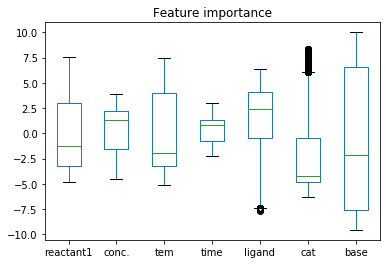


You are all set! Have a good one, mate!

End: 2019/09/18  14:42:23


In [52]:
# ALL CODE:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# from sklearn.externals.joblib import dump
import seaborn as sns
import time
from treeinterpreter import treeinterpreter as ti
import matplotlib.pyplot as plt

def get_colu_num_numerical(filename1_df):#X with no label
    colu = filename1_df.iloc[:,:-1].select_dtypes(exclude=['object']) #extract  columns
    num = len(colu.columns) #get the number of  columns
    return colu, num

def get_colu_num_catagorical(filename1_df):#X with no label
    colu = filename1_df.iloc[:,:-1].select_dtypes(include=['object']) #extract  columns
    num = len(colu.columns) #get the number of  columns
    return colu, num

# find index in all_combos of train_data  
#先在all里面加入索引，然后merge 去交际，留下交际，得到index
def get_train_OHE(filename1_df, all_combos_df):
    All_OHE_df = pd.get_dummies(all_combos_df) # OHE for all data
    copy_df = all_combos_df.copy()
    copy_df['index'] = np.arange(len(all_combos_df.iloc[:,1]))# Creat a new colum for index in all
    X = filename1_df.iloc[:,:-1] #X
    merge_df = pd.merge(copy_df, X, how='inner') #Merge data from unconverted formation
    index_lst = merge_df['index'].tolist()
    X_OHE_df = All_OHE_df.iloc[index_lst,:]
    return X_OHE_df

# Get the index of each catagorical data
def get_OHE_index(filename1_df): #from your X
    #get unique num:
    Numerical_colu, Numerical_num = get_colu_num_numerical(filename1_df)#get the number of numerical columns, one-hot-encoded columns should appear behind them.
    Discrete_colu, Discrete_num = get_colu_num_catagorical(filename1_df)
    unique_num = []
    for i in Discrete_colu.columns:
        unique_num.append(len(Discrete_colu[i].unique()))
    index = [Numerical_num]
    count = Numerical_num
    for i in unique_num[:-1]:
        count = count + int(i)
        index.append(count)
    print('Index of OHE:',index)
    return index

#tree interpreter for feature importance
#以下是tree interpreter的集成代码
def plot_tree(model,filename1_df, all_combos_df): #model, filename1_df is dataframe of train data. All is dataframe of allcombos.
    All_OHE_df = pd.get_dummies(all_combos_df)
    prediction, bias, contributions = ti.predict(model, All_OHE_df)
    contributions = pd.DataFrame(contributions, columns=All_OHE_df.columns) #get all the contributions
    X = filename1_df.iloc[:,:-1]
    index = get_OHE_index(X)
    Numerical_colu, Numerical_num = get_colu_num_numerical(filename1_df)
    Discrete_colu, Discrete_num = get_colu_num_catagorical(filename1_df)
    Discrete_colu_name = Discrete_colu.columns
    unique_num = []
    for i in Discrete_colu.columns:
        unique_num.append(len(Discrete_colu[i].unique()))
    numerical_contri_df = contributions.iloc[:,:Numerical_num]
    discrete_contri_df = pd.DataFrame()
    for i in range(Discrete_num):
        posi = index[i]
        increment = unique_num[i]
        discrete_contri_df[Discrete_colu_name[i]] = contributions.iloc[:,posi:posi+increment].sum(1)
    contri_all_df = pd.concat([numerical_contri_df, discrete_contri_df], axis=1)
    plt.figure(figsize=(12, 20))
    contri_all_df.plot.box()
    plt.title('Feature importance')
    plt.savefig('Feature importance.png')
    plt.show()

#load data
print('Welcome! Let me work out what is the best experiment for you to run...')
#filename1 = input("Please type in your train data file name: ")
#filename2 = input('Please type in your chemical space file name: ')
print('\nStart:', time.strftime("%Y/%m/%d  %H:%M:%S"))
filename1 = 'train_data.xlsx'
filename2 = 'all_combos.xlsx'
print('\nLoading: ', filename1)

filename1_df = pd.read_excel(filename1)
all_combos_df = pd.read_excel(filename2)
y = filename1_df.iloc[:,-1]
X = filename1_df.iloc[:,:-1]
All_OHE_df = pd.get_dummies(all_combos_df)
# df_train_corrected = train.iloc[:,:-1]
X_OHE_df = get_train_OHE(filename1_df, all_combos_df)
unseen = pd.concat([All_OHE_df, X_OHE_df]).drop_duplicates(keep=False) # drop when you get index
#process
#process

print('\nAll good till now. I am figuring out the best method to analyze your data. Bear with me...')
#General stuff
seed = 1234
kfold = KFold(n_splits = 2, random_state = seed)#
scoring = 'neg_mean_absolute_error'
model = RandomForestRegressor(random_state=seed)

#Parameters to tune
# estimators = np.arange(100, 1050, 50) 
# estimators_int = np.ndarray.tolist(estimators)
estimators_int = [200, 500]
param_grid = {'n_estimators':estimators_int, 'max_features':['auto', 'sqrt'],
              'max_depth':[None ]}#
#search best parameters and train
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)
grid_result = grid.fit(X_OHE_df, y)

#print the best data cranked out from the grid search
np.savetxt('Model_best_score_MAE.txt', ["best_score: %s" % grid.best_score_], fmt ='%s')
best_params = pd.DataFrame([grid.best_params_], columns=grid.best_params_.keys())
best_params.to_csv('best_parameters.txt', sep= '\t')

print('\n... done! It is going to be lightspeed from here on out! :)')
#predict future data

model2 = grid.best_estimator_
# model2 = RandomForestRegressor(n_estimators = grid.best_params_['n_estimators'], max_features = grid.best_params_['max_features'], max_depth = grid.best_params_['max_depth'], random_state = seed)
RF_fit = model2.fit(X_OHE_df, y)
predictions = model2.predict(unseen)
predictions_df = pd.DataFrame(data=predictions, columns=['Prediction'])

# #feature importance
# feat_imp = pd.DataFrame(model2.feature_importances_,
#                         index=train.iloc[:,1:-1].columns,
#                         columns=['Feature_importances'])
# feat_imp = feat_imp.sort_values(by=['Feature_importances'], ascending = False)

all_predictions = []
for e in model2.estimators_:
    all_predictions += [e.predict(unseen)]

variance = np.var(all_predictions, axis=0)
variance_df = pd.DataFrame(data=variance, columns=['Variance'])

assert len(variance) == len(predictions)
unseen_combos_df = pd.concat([all_combos_df, X]).drop_duplicates(keep=False)
df = pd.concat([unseen_combos_df, predictions_df, variance_df], axis=1)

print('Analysing feature importance for you...')
plot_tree(model2, filename1_df, all_combos_df)
#save data
df.to_csv('predictions.csv',index=False)
print('\nYou are all set! Have a good one, mate!')#all_comboss.csv
print('\nEnd:', time.strftime("%Y/%m/%d  %H:%M:%S"))#train_data.csv

In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# from sklearn.externals.joblib import dump
import seaborn as sns
import time
from treeinterpreter import treeinterpreter as ti
import matplotlib.pyplot as plt

#load data
print('Welcome! Let me work out what is the best experiment for you to run...')
#filename1 = input("Please type in your train data file name: ")
#filename2 = input('Please type in your chemical space file name: ')
print('\nStart:', time.strftime("%Y/%m/%d  %H:%M:%S"))
filename1 = 'train_data.xlsx'
filename2 = 'all_combos.xlsx'
print('\nLoading: ', filename1)

filename1_df = pd.read_excel(filename1)
all_combos_df = pd.read_excel(filename2)
y = filename1_df.iloc[:,-1]
X = filename1_df.iloc[:,:-1]
# all_combos_df['index'] = np.arange(len(all_combos_df.iloc[:,1]))
All_OHE_df = pd.get_dummies(all_combos_df)
# df_train_corrected = train.iloc[:,:-1]
X_OHE_df = get_train_OHE(filename1_df, all_combos_df)
unseen = pd.concat([All_OHE_df, X_OHE_df]).drop_duplicates(keep=False) # drop when you get index
#process

Numerical_colu, Numerical_num = get_colu_num_numerical(filename1_df)#get the number of numerical columns, one-hot-encoded columns should appear behind them.
Discrete_colu, Discrete_num = get_colu_num_catagorical(filename1_df)

Welcome! Let me work out what is the best experiment for you to run...

Start: 2019/09/18  14:24:56

Loading:  train_data.xlsx


In [44]:
# find index in all_combos of train_data  
#先在all里面加入索引，然后merge 去交际，留下交际，得到index
def get_train_OHE(filename1_df, all_combos_df):
    All_OHE_df = pd.get_dummies(all_combos_df) # OHE for all data
    all_combos_df['index'] = np.arange(len(all_combos_df.iloc[:,1]))# Creat a new colum for index in all
    X = filename1_df.iloc[:,:-1] #X
    merge_df = pd.merge(all_combos_df, X, how='inner') #Merge data from unconverted formation
    index_lst = merge_df['index'].tolist()
    X_OHE_df = All_OHE_df.iloc[index_lst,:]
    return X_OHE_df

X_OHE_df = get_train_OHE(filename1_df, all_combos_df)

In [2]:
def get_colu_num_numerical(filename1_df):#X with no label
    colu = filename1_df.iloc[:,:-1].select_dtypes(exclude=['object']) #extract  columns
    num = len(colu.columns) #get the number of  columns
    return colu, num

def get_colu_num_catagorical(filename1_df):#X with no label
    colu = filename1_df.iloc[:,:-1].select_dtypes(include=['object']) #extract  columns
    num = len(colu.columns) #get the number of  columns
    return colu, num

Numerical_colu, Numerical_num = get_colu_num_numerical(filename1_df)#get the number of numerical columns, one-hot-encoded columns should appear behind them.
Discrete_colu, Discrete_num = get_colu_num_catagorical(filename1_df)

In [3]:
# Get the index of each catagorical data
def get_OHE_index(filename1_df): #from your X
    #get unique num:
    Numerical_colu, Numerical_num = get_colu_num_numerical(filename1_df)#get the number of numerical columns, one-hot-encoded columns should appear behind them.
    Discrete_colu, Discrete_num = get_colu_num_catagorical(filename1_df)
    unique_num = []
    for i in Discrete_colu.columns:
        unique_num.append(len(Discrete_colu[i].unique()))
    index = [Numerical_num]
    count = Numerical_num
    for i in unique_num[:-1]:
        count = count + int(i)
        index.append(count)
    print('Index of OHE:',index)
    return index

In [93]:
print('\nAll good till now. I am figuring out the best method to analyze your data. Bear with me...')
#General stuff
seed = 1234
kfold = KFold(n_splits = 2, random_state = seed)#
scoring = 'neg_mean_absolute_error'
model = RandomForestRegressor(random_state=seed)

#Parameters to tune
# estimators = np.arange(100, 1050, 50) 
# estimators_int = np.ndarray.tolist(estimators)
estimators_int = [200, 500]
param_grid = {'n_estimators':estimators_int, 'max_features':['auto', 'sqrt'],
              'max_depth':[None ]}#
#search best parameters and train
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)
grid_result = grid.fit(X_OHE_df, y)

#print the best data cranked out from the grid search
np.savetxt('Model_best_score_MAE.txt', ["best_score: %s" % grid.best_score_], fmt ='%s')
best_params = pd.DataFrame([grid.best_params_], columns=grid.best_params_.keys())
best_params.to_csv('best_parameters.txt', sep= '\t')



All good till now. I am figuring out the best method to analyze your data. Bear with me...


In [95]:
print('\n... done! It is going to be lightspeed from here on out! :)')
#predict future data

model2 = grid.best_estimator_
# model2 = RandomForestRegressor(n_estimators = grid.best_params_['n_estimators'], max_features = grid.best_params_['max_features'], max_depth = grid.best_params_['max_depth'], random_state = seed)
RF_fit = model2.fit(X_OHE_df, y)
predictions = model2.predict(unseen)
predictions_df = pd.DataFrame(data=predictions, columns=['Prediction'])

# #feature importance
# feat_imp = pd.DataFrame(model2.feature_importances_,
#                         index=train.iloc[:,1:-1].columns,
#                         columns=['Feature_importances'])
# feat_imp = feat_imp.sort_values(by=['Feature_importances'], ascending = False)

all_predictions = []
for e in model2.estimators_:
    all_predictions += [e.predict(X2)]

variance = np.var(all_predictions, axis=0)
variance_df = pd.DataFrame(data=variance, columns=['Variance'])

assert len(variance) == len(predictions)
unseen_combos_df = pd.concat([all_combos_df, X]).drop_duplicates(keep=False)
df = pd.concat([unseen_combos_df, predictions_df, variance_df], axis=1)

,ligand,cat,reactant1,conc.,tem,time,Prediction,Variance
0,ph2,ca,0.1,0.05,110.0,10.0,20.590,5.641900
1,ph2,ca,0.1,0.05,110.0,11.0,20.725,5.769375
2,ph2,ca,0.1,0.05,110.0,14.0,20.430,6.325100
3,ph2,ca,0.1,0.05,110.0,15.0,20.420,6.343600
4,ph2,ca,0.1,0.05,110.0,16.0,20.710,6.275900


In [96]:
#tree interpreter for feature importance
#以下是tree interpreter的集成代码
def plot_tree(model,filename1_df, all_combos_df): #model, filename1_df is dataframe of train data. All is dataframe of allcombos.
    All_OHE_df = pd.get_dummies(all_combos_df)
    prediction, bias, contributions = ti.predict(model, All_OHE_df)
    contributions = pd.DataFrame(contributions, columns=All_OHE_df.columns) #get all the contributions
    X = filename1_df.iloc[:,:-1]
    index = get_OHE_index(X)
    Numerical_colu, Numerical_num = get_colu_num_numerical(filename1_df)
    Discrete_colu, Discrete_num = get_colu_num_catagorical(filename1_df)
    Discrete_colu_name = Discrete_colu.columns
    unique_num = []
    
    for i in Discrete_colu.columns:
        unique_num.append(len(Discrete_colu[i].unique()))
    numerical_contri_df = contributions.iloc[:,:Numerical_num]
    discrete_contri_df = pd.DataFrame()
    for i in range(Discrete_num):
        posi = index[i]
        increment = unique_num[i]
        discrete_contri_df[Discrete_colu_name[i]] = contributions.iloc[:,posi:posi+increment].sum(1)
    contri_all_df = pd.concat([numerical_contri_df, discrete_contri_df], axis=1)
    plt.figure(figsize=(12, 20))
    contri_all_df.plot.box()
    plt.title('Feature importance')
    plt.savefig('Feature importance.png')
    plt.show()

Analysing feature importance for you...
Index of OHE: [3, 7]


<Figure size 864x1440 with 0 Axes>

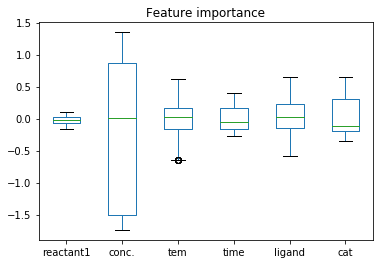

In [97]:
print('Analysing feature importance for you...')
plot_tree(model2, filename1_df, all_combos_df)
#save data
df.to_csv('predictions.csv',index=False)
print('\nYou are all set! Have a good one, mate!')#all_comboss.csv
print('\nEnd:', time.strftime("%Y/%m/%d  %H:%M:%S"))#train_data.csv